In [1]:
from __future__ import print_function
from __future__ import division

import os
import math
import matplotlib.pyplot as plt

import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time
from voronoi_2d_binning import voronoi_2d_binning
from sklearn.neighbors import NearestNeighbors
import pickle
import imp # reload modules if necessary

In [2]:
import binning
import bin_debiasing
import fit_debiasing
import make_dictionaries
import params

In [3]:
% matplotlib inline
import matplotlib as mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [4]:
os.mkdir('output_files/') if os.path.isdir('output_files/') is False else None

source_directory = params.source_directory
full_sample = params.full_sample

min_log_fv = -1.5
max_log_fv = 0.01 

In [45]:
full_data = Table.read(source_directory + full_sample)
print('Loaded galaxy data...')

Loaded galaxy data...


In [6]:
questions = make_dictionaries.questions
print('Loaded questions...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded functions...')

Loaded questions...
Loaded functions...


In [7]:
def reduce_sample(full_data,questions,question,p_cut=0.5,N_cut=5,normalised_values=True):
    ''' Reduce the sample to p>p_cut galaxies only, 
        using the precedeing questions'''
    
    previous_q = questions[question]['pre_questions']
    previous_a = questions[question]['pre_answers']
    
    if normalised_values == True:
        suffix = '_debiased_rh_normalised'
    else:
        suffix = '_debiased_rh'
    
    if previous_q != None:
        
        p_col = np.ones(len(full_data))
        
        for m in range(len(previous_q)):
            p_col = p_col*(full_data[previous_q[m] + '_' + previous_a[m] + suffix])
        N_col = (full_data[previous_q[-1] + '_' + previous_a[-1] + '_count'])
        
        select = (p_col > p_cut) & (N_col >= N_cut)
        data_reduced = full_data[select]
        print('{}/{} galaxies with p>{} and N>={}.'.format(len(data_reduced),
                                                          len(full_data),p_cut,N_cut))
    
    else:
        data_reduced = full_data.copy()
        print('Primary question, so all {} galaxies used.'.format(len(data_reduced)))
    
    return data_reduced

In [8]:
def get_bins(question,answer):
    ''' Get bins if they have already been created from a 
        previous running of the debiasing'''
    
    bins = Table.read('output_files/'+ question + '/' + answer + '/bins.fits')
    all_bins = Table.read('output_files/'+ question + '/' + answer + '/all_bins.fits')
    vbins_table = Table.read('output_files/'+ question + '/' + answer + '/vbin_parameters.fits')
    
    vbins = bins['vbin']
    zbins = bins['zbin']
    zbins_coarse = bins['coarse_zbin']
    vbins_all = all_bins['vbin']
    zbins_all = all_bins['zbin']
    zbins_coarse_all = all_bins['coarse_zbin']
    
    return vbins,zbins,zbins_coarse,vbins_all,zbins_all,zbins_coarse_all,vbins_table

In [9]:
def histogram_fractions(data,hist_bins):
    ''' Get raw histogram values '''
    h,bin_edges = np.histogram(data,bins=hist_bins)
    f = h/np.sum(h)
    return f


def bin_by_column(column, nbins, fixedcount=True):
    ''' Bin the data into redshift slices 
    (or by any column) '''
    
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins


def get_rms(dataset,reference,redshifts):
    ''' Calculate rms of a dataset in comparison w. reference data'''
    hist_bins = np.linspace(0,1,11)
    hist_bins[0] = -1
    hist_bins[-1] = 2
    zv,zb = bin_by_column(redshifts,nbins=10)
    
    rms_values = np.zeros(len(np.unique(zb)))
    ref_fractions = histogram_fractions(reference,hist_bins)
    
    for i,z in enumerate(np.unique(zb)):
        
        sample = dataset[zb == z]
        fractions = histogram_fractions(sample,hist_bins)
        rms_values[i] = np.sum((fractions-ref_fractions)**2)
    
    return np.sum(rms_values)

In [10]:
def choose_best_function(raw_data,debiased,question,answer):
    ''' Decide on which set of debiasing values is preferred'''
    volume_ok = raw_data['in_volume_limit'] == 1
    
    # Raw data for reference:
    vl  = raw_data[volume_ok][question + '_' + answer]
    
    # 2 sets of debiased data for comparison:
    vl_bin = debiased['bin_method'][volume_ok]
    vl_fit = debiased['fit_method'][volume_ok]
    redshifts = full_data['Z_TONRY'][volume_ok]
    
    low_z = (redshifts >= 0.03) & (redshifts < 0.035)
    reference = vl[low_z] # raw low-z for comparison
    
    rms_bin = get_rms(vl_bin,reference,redshifts) # get rms values
    rms_fit = get_rms(vl_fit,reference,redshifts) # get rms values
    
    print('rms^2(bin) = {0:.3f}'.format(rms_bin))
    print('rms^2(fit) = {0:.3f}'.format(rms_fit))
    if rms_bin < rms_fit:
        print('---> bin method selected')
        debiased_values = debiased['bin_method']
    else:
        print('---> fit method selected')
        debiased_values = debiased['fit_method'] # Prefer fit method if it 
        # has better rms^2 value.
        
    return debiased_values

In [25]:
def bin_and_debias(full_data,question,questions,answer
                   ,bins_exist=False,n_per_bin=100,coarse=False):
    '''Set to 'coarse' to make the fitting only apply to the 'coarse binning'of 4 redshift bins per 
    voronoi bin rather than the fully binned data'''
    
    # Create output file folders:
    (os.mkdir('output_files/'+ question) if
     os.path.isdir('output_files/'+ question) is False else None)
    (os.mkdir('output_files/'+ question + '/' + answer) if
     os.path.isdir('output_files/'+ question + '/' + answer) is False else None)
    
    # Only use the p>0.5 and N>= 5 data for a given question:
    data = reduce_sample(full_data,questions,question)
    
    if bins_exist == True:
        (vbins,zbins,zbins_coarse,
         vbins_all,zbins_all,zbins_coarse_all,
         vbins_table) = get_bins(question,answer)
        print('Bins obtained from previous iteration...')
        
    else:
        (vbins,zbins,zbins_coarse,
         vbins_all,zbins_all,zbins_coarse_all,
         vbins_table) = binning.bin_data(data,full_data,
                                        question,answer,
                                        signal=n_per_bin)
        
    # Save the binning data:
    bin_table = Table([vbins,zbins,zbins_coarse],names=('vbin','zbin','coarse_zbin'))
    all_bin_table = Table([vbins_all,zbins_all,zbins_coarse_all],names=('vbin','zbin','coarse_zbin'))
    bin_table.write('output_files/'+ question + '/' + answer + '/bins.fits',overwrite=True)
    all_bin_table.write('output_files/'+ question + '/' + answer + '/all_bins.fits',overwrite=True)
    vbins_table.write('output_files/'+ question + '/' + answer + '/vbin_parameters.fits',overwrite=True)

    # Debias using the discrete bin method 1st:
    debiased_bin = bin_debiasing.debias(data,full_data,vbins,zbins,vbins_all,zbins_all,question,answer)
    # Now debias using the functional fitting method:
    debiased_fit,dout,fit_setup,zbins,fit_vbin_results = fit_debiasing.debias_by_fit(data,full_data,vbins,zbins,
                                                                                     zbins_coarse,question,answer,
                                                                                     function_dictionary,min_log_fv,
                                                                                     coarse=coarse)
    
    volume_ok = data['in_volume_limit'] == 1    
    vl_data = full_data[volume_ok]
    vl_fit = debiased_fit[volume_ok]
    vl_bin = debiased_bin[volume_ok]

    debiased_table = Table([debiased_bin,debiased_fit],names=('bin_method','fit_method'))
    debiased_table.write('output_files/'+ question + '/' + answer + '/debiased.fits',overwrite=True)
    dout.write('output_files/'+ question + '/' + answer + '/fit_results.fits',overwrite=True)
    pickle.dump(fit_setup,open('output_files/'+ question + '/' + answer + '/fit_setup.p', "wb" ))
    
    return debiased_table

In [51]:
import imp
imp.reload(binning)
imp.reload(params)
imp.reload(bin_debiasing)
imp.reload(fit_debiasing)

<module 'fit_debiasing' from '/Users/rosshart/Desktop/Debiasing/fit_debiasing.py'>

In [52]:
question_order = ['shape',
                  'disk',
                  'bar',
                  'spiral_a',
                  'bulge_a',
                  'round',
                  'bulge_b',
                  'spiral_b',
                  'spiral_c']

for question in question_order[:1]:
    answers = questions[question]['answers']
    
    for answer in answers:
        
        #bins_exist = os.path.isfile('output_files/'+ question + '/' + answer + '/bins.fits')
        bins_exist = False
        
        print('----------------------------------')
        print('Question to be debiased:',question)
        print('Answer to be debiased:',answer)
        
        debiased = bin_and_debias(full_data,question,questions,answer,
                                  bins_exist=bins_exist,n_per_bin=50,coarse=False) # Use smaller bins!
        
        deb_vals = choose_best_function(full_data,debiased,question,answer)
        full_data[question + '_' + answer + '_debiased_rh'] = deb_vals
        
        print('----------------------------------')

    debiased_values = np.array([full_data[question + '_' + a + '_debiased_rh'] for a in answers])
    debiased_norm = debiased_values/np.sum(debiased_values,axis=0)
    debiased_norm[np.isnan(debiased_norm)] = 0
    for m in range(len(debiased_norm)):
        full_data[question + '_' + answers[m] + '_debiased_rh_normalised'] = debiased_norm[m]

----------------------------------
Question to be debiased: shape
Answer to be debiased: smooth
Primary question, so all 11330 galaxies used.
Bin-accretion...
76  initial bins.
Reassign bad bins...
16  good bins.
Modified Lloyd algorithm...
14  iterations.
Unbinned pixels:  0  /  1642
Fractional S/N scatter (%): 27.8045315001
17 voronoi bins
13.235294117647058 redshift bins per voronoi bin
vbin -1 has too low signal!
vbin 5 has too low signal!
All bins fitted! 14.215795993804932s in total
chisq(logistic) = 0.002934357183057094
vbin -1 has too low signal!
vbin 5 has too low signal!
All bins fitted! 10.34506106376648s in total
chisq(exp. power) = 0.0016722026200820155
vbin -1 has too low signal!
vbin 5 has too low signal!
All bins fitted! 31.294265031814575s in total

/Users/rosshart/anaconda/lib/python3.4/site-packages/astropy/table/column.py:1086: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/Users/rosshart/Desktop/Debiasing/fit_debiasing.py:284: RuntimeWarning: invalid value encountered in log10
  if t == 'log':



Selected functions:------
k: linear(M),exp(R),log(z)
c: linear(M),linear(R),exp(z)
rms^2(bin) = 4.816
rms^2(fit) = 4.810
---> fit method selected
----------------------------------
----------------------------------
Question to be debiased: shape
Answer to be debiased: features
Primary question, so all 11330 galaxies used.
Bin-accretion...
47  initial bins.
Reassign bad bins...
15  good bins.
Modified Lloyd algorithm...
13  iterations.
Unbinned pixels:  0  /  1541
Fractional S/N scatter (%): 20.082122548
16 voronoi bins
13.75 redshift bins per voronoi bin
All bins fitted! 11.137977123260498s in total
chisq(logistic) = 0.0012444938496297346
All bins fitted! 11.86443018913269s in total
chisq(exp. power) = 0.00027590442564512293
All bins fitted! 31.28357696533203s in total
Selected functions:------

/Users/rosshart/anaconda/lib/python3.4/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/rosshart/anaconda/lib/python3.4/site-packages/numpy/core/fromnumeric.py:2886: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/rosshart/anaconda/lib/python3.4/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide



k: linear(M),linear(R),linear(z)
c: linear(M),linear(R),log(z)
rms^2(bin) = nan
rms^2(fit) = nan
---> fit method selected
----------------------------------
----------------------------------
Question to be debiased: shape
Answer to be debiased: star_or_artifact
Primary question, so all 11330 galaxies used.
Bin-accretion...
109  initial bins.
Reassign bad bins...
16  good bins.
Modified Lloyd algorithm...
14  iterations.
Unbinned pixels:  0  /  1669
Fractional S/N scatter (%): 14.1464890701
16 voronoi bins
13.75 redshift bins per voronoi bin
All bins fitted! 11.57551097869873s in total
chisq(logistic) = 0.00036217173954542945
All bins fitted! 12.219735145568848s in total
chisq(exp. power) = 0.00027631280066781196
All bins fitted! 31.728858947753906s in total
Selected functions:------
k: linear(M),exp(R),linear(z)
c: linear(M),exp(R),log(z)
rms^2(bin) = 13.031
rms^2(fit) = 12.684
---> fit method selected
----------------------------------


Save the debiased values to a FITS file, which can be combined in to full sample using Recover_full_data.ipynb

In [14]:
debiased_columns = []

for m in range(len(full_data.colnames)):
    c = full_data.colnames[m]
    if 'debiased_rh' in c:
        debiased_columns.append(c)
        
debiased_values = full_data[debiased_columns]
debiased_values.write(source_directory + 'debiased_values.fits',overwrite=True)

/Users/rosshart/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


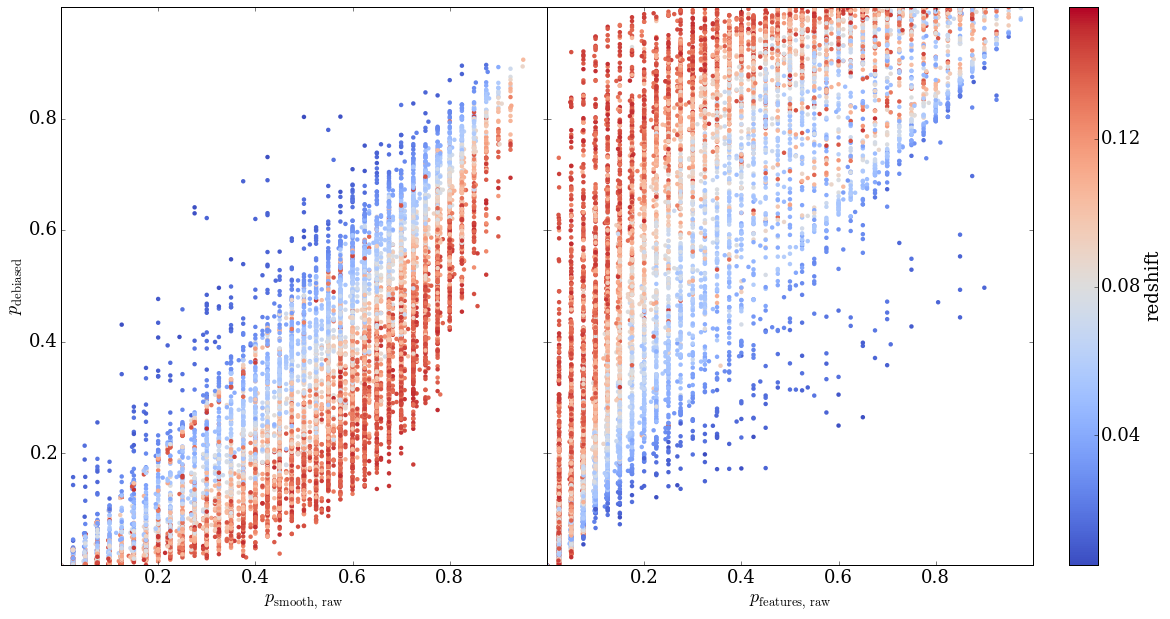

In [126]:
fig, axarr = plt.subplots(1,2,figsize=(20,10),sharex=True,sharey=True)
fig.subplots_adjust(wspace=0,hspace=0)

z = full_data['Z_TONRY']
scaled_z = (z - z.min()) / z.ptp()
colors = plt.cm.coolwarm(scaled_z)

s = axarr[0].scatter(full_data['shape_smooth_fraction'],full_data['shape_smooth_debiased_rh'],
                     c=z,lw=0,s=20,cmap=plt.cm.coolwarm)

s = axarr[1].scatter(full_data['shape_features_fraction'],full_data['shape_features_debiased_rh'],
                     c=z,lw=0,s=20,cmap=plt.cm.coolwarm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.825, 0.125, 0.02, 0.775])
fig.colorbar(s, cax=cbar_ax,label='redshift')

_ = axarr[0].set_xlabel('$p_\mathrm{smooth, \, raw}$')
_ = axarr[1].set_xlabel('$p_\mathrm{features, \, raw}$')
_ = axarr[0].set_ylabel('$p_\mathrm{debiased}$')
_ = axarr[0].set_xlim(0,1)
_ = axarr[0].set_ylim(0,1)

fig.savefig('shape_debiased.pdf')